# Photometry data preprocessing

This notebook shows methods for preprocessing fiber photometry data. This notebook was heavily modeled after after a previously developed [notebook with similar aims](https://github.com/ThomasAkam/photometry_preprocessing/blob/master/Photometry%20data%20preprocessing.ipynb), and all credit should go to it's creator Thomas Akam.

Preprocessing consists of:

1. Filterining to reduce noise.

2. Correction for photobleaching.

3. Movement correction.

4. Calculation of the dF/F.

Note that different groups do preprocessing differently and there is no universally accepted best practice for how to preprocess photometry data. It is good practice to always visually inspect the raw data and the results of each preprocessing step to make sure they look sensible.

The data used in this notebook were recorded from XX region using GCaMP6f (470 nm) with an isosbestic contrtol (410 nm)


In [1]:
# ===============================================
# Import essential modules
# ===============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize
%matplotlib inline 
plt.rcParams['figure.figsize'] = [14, 12] # Make default figure size larger.
plt.rcParams['axes.xmargin'] = 0          # Make default margin on x axis zero.

# Import data

In [5]:
# change path to data folder
path = os.getcwd()
parent_dir = os.path.dirname(path)
data_dir = f"{parent_dir}/data"
os.chdir(data_dir)


# import data from .csv files
fs = 30 # Thirty samples/seconds

JM1_IED_415 = pd.read_csv('JM1 IED 410.csv') # Isosbestic
JM1_IED_470 = pd.read_csv('JM1 IED 470.csv') # GCaMP
regions = JM1_IED_415.columns[3:]

ISOS_raw = JM1_IED_415[regions[3]] # only selecting one region
GCaMP_raw = JM1_IED_470[regions[3]]
time_seconds = np.arange(0, len(GCaMP_raw)/30, 1/fs) # get time in seconds

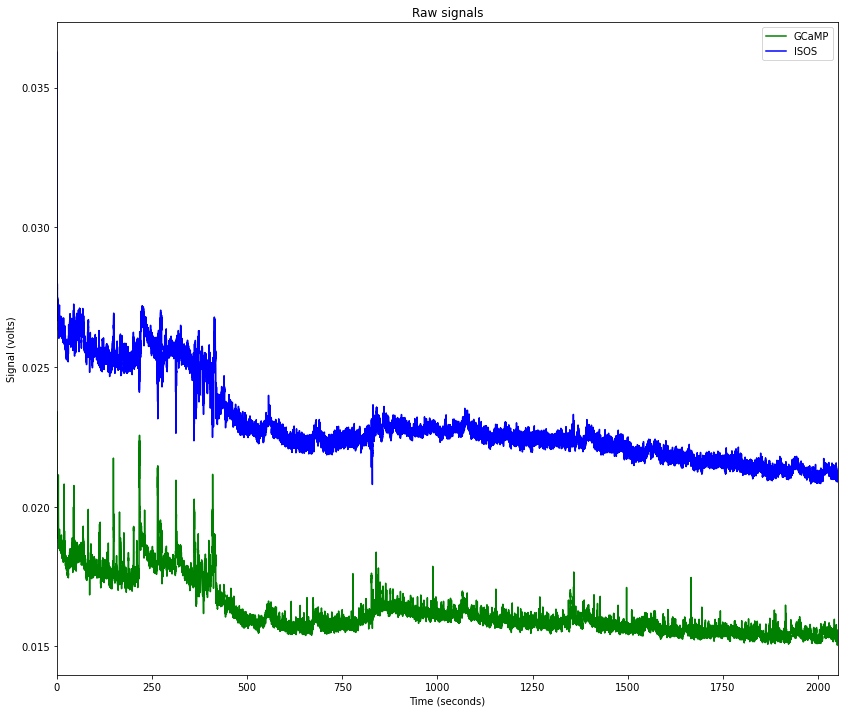

In [6]:
fig = plt.figure()
plt.plot(time_seconds, GCaMP_raw, 'g', label='GCaMP')
plt.plot(time_seconds, ISOS_raw, 'b', label='ISOS')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Raw signals')
plt.legend()

# Denoising

Artifacts due to electrical noise can be greatly reduced by running a median filter before the standard low pass filter.  We then lowpass filter the signals to reduce high-frequency jitter, using a zero phase filter with a 10Hz cutoff frequency.

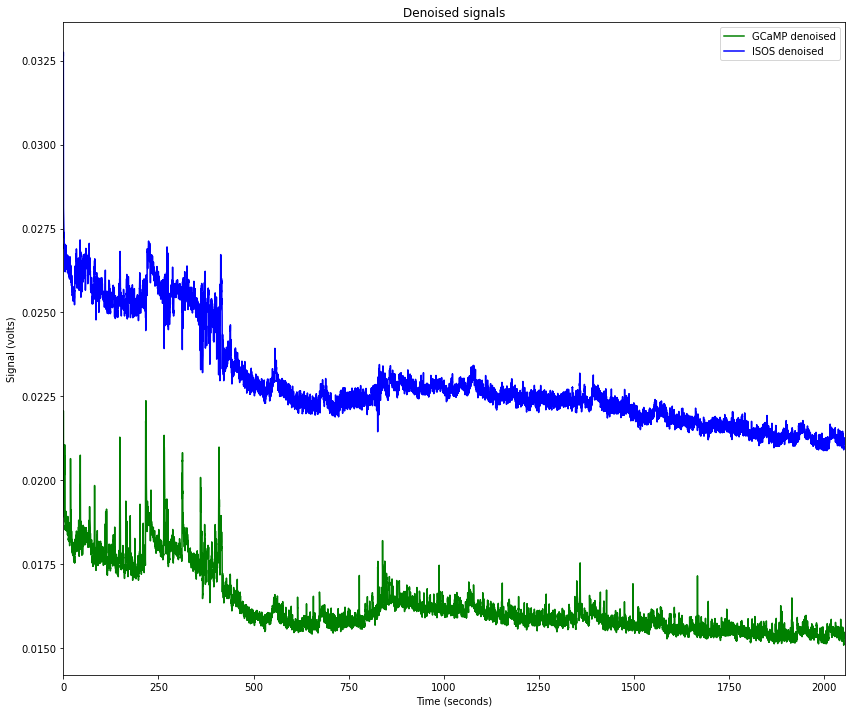

In [29]:
# Median filtering to remove electrical artifact.
GCaMP_denoised = medfilt(GCaMP_raw, kernel_size=5)
ISOS_denoised = medfilt(ISOS_raw, kernel_size=5)
 
# Lowpass filter - zero phase filtering (with filtfilt) is used to avoid distorting the signal.
b,a = butter(2, 10, btype='low', fs=30)
GCaMP_denoised = filtfilt(b,a, GCaMP_denoised)
ISOS_denoised = filtfilt(b,a, ISOS_denoised)

#plt.plot(time_seconds, GCaMP_raw, label='GCaMP')
#plt.plot(time_seconds, TdTom_raw, label='TdTomato')
plt.plot(time_seconds, GCaMP_denoised, 'g', label='GCaMP denoised')
plt.plot(time_seconds, ISOS_denoised, 'b', label='ISOS denoised') 
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Denoised signals')
plt.legend();

(0.015, 0.03)

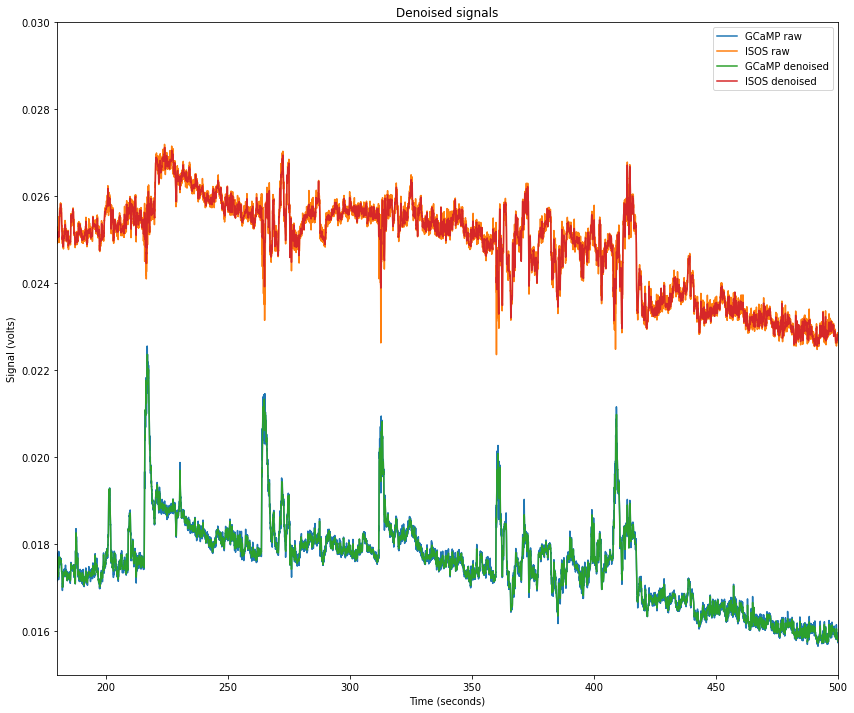

In [30]:
plt.plot(time_seconds, GCaMP_raw, label='GCaMP raw')
plt.plot(time_seconds, ISOS_raw, label='ISOS raw')
plt.plot(time_seconds, GCaMP_denoised, label='GCaMP denoised')
plt.plot(time_seconds, ISOS_denoised, label='ISOS denoised') 
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Denoised signals')
plt.legend()
plt.xlim(180,500)
plt.ylim(0.015,0.03)

# Photobleaching correction

Now lets compare some different ways of removing the influence of photobleaching.

A simple way to remove slow changes is simply to highpass filter the signal with a very low cutoff frequency. Here we will high pass at 0.001Hz, which correponds to a period of 16 minutes.  All components of the signal changing on a slower timescale than this will be removed, which removes the drift due to bleaching, but will also remove any physiological variation in the signal on very slow timescales.

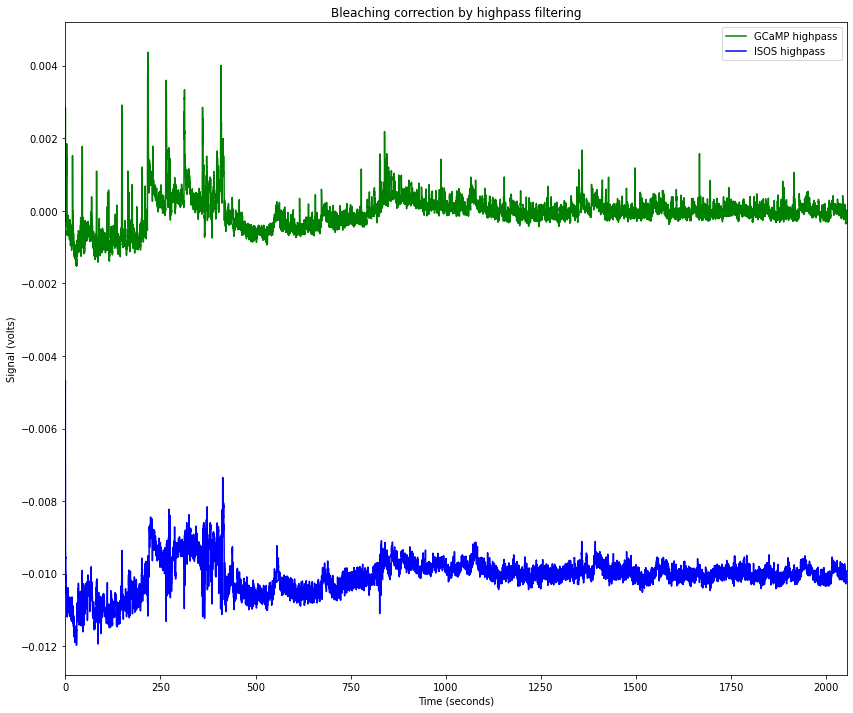

In [31]:
b,a = butter(2, 0.001, btype='high', fs=30)
GCaMP_highpass = filtfilt(b,a, GCaMP_denoised, padtype='even')
ISOS_highpass = filtfilt(b,a, ISOS_denoised, padtype='even')

plt.plot(time_seconds, GCaMP_highpass    ,'g', label='GCaMP highpass')
plt.plot(time_seconds, ISOS_highpass-.01,'b', label='ISOS highpass')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Bleaching correction by highpass filtering')
plt.legend();

A second possible way of removing the influence of bleaching is to fit an exponential decay to the data and subtract this exponential fit from the signal.

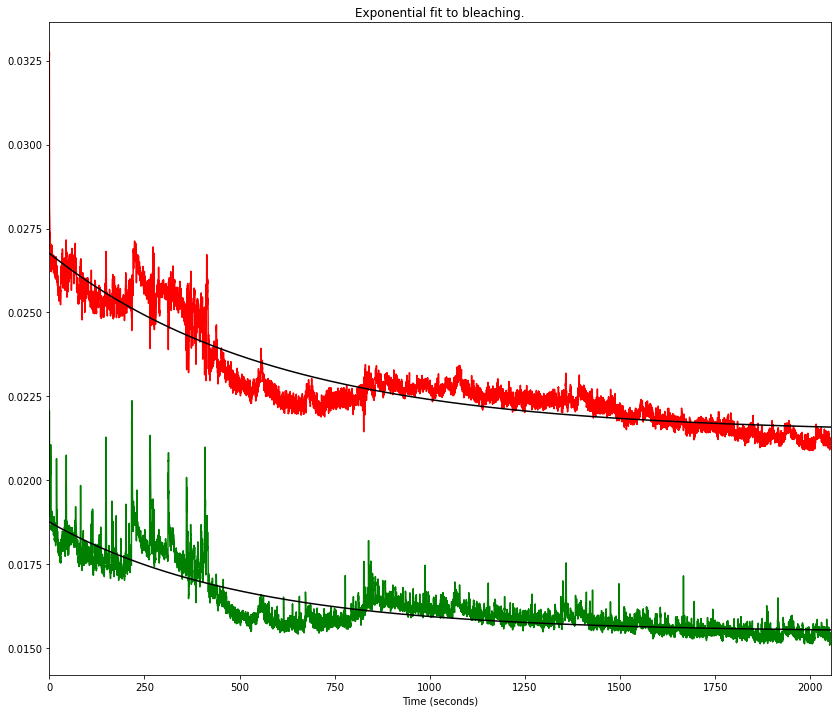

In [33]:
# The exponential curve we are going to fit.
def exp_func(x, a, b, c):
   return a*np.exp(-b*x) + c

# Fit curve to GCaMP signal.
GCaMP_parms, parm_cov = curve_fit(exp_func, time_seconds, GCaMP_denoised, p0=[1,1e-3,1],bounds=([0,0,0],[4,0.1,4]), maxfev=1000)
GCaMP_expfit = exp_func(time_seconds, *GCaMP_parms)

# Fit curve to TdTomato signal.
ISOS_parms, parm_cov = curve_fit(exp_func, time_seconds, ISOS_denoised, p0=[1,1e-3,1],bounds=([0,0,0],[4,0.1,4]), maxfev=1000)
ISOS_expfit = exp_func(time_seconds, *ISOS_parms)

plt.plot(time_seconds, GCaMP_denoised, 'g', label='GCaMP')
plt.plot(time_seconds, GCaMP_expfit,'k', linewidth=1.5) 
plt.plot(time_seconds, ISOS_denoised, 'r', label='ISOS')
plt.plot(time_seconds, ISOS_expfit,'k', linewidth=1.5) 
plt.title('Exponential fit to bleaching.')
plt.xlabel('Time (seconds)');

Now subtract the exponential fits from the signals.

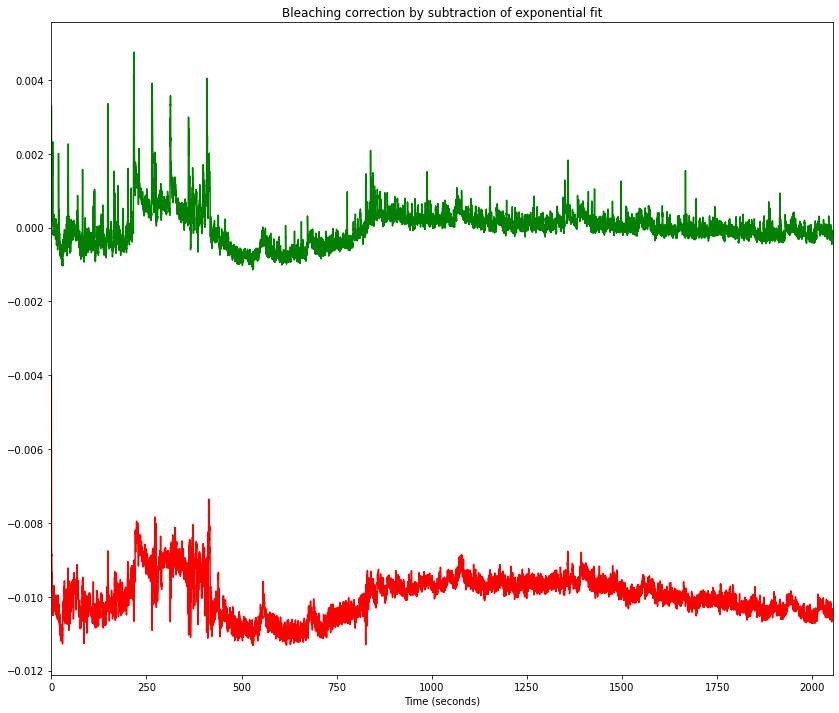

In [35]:
GCaMP_es = GCaMP_denoised - GCaMP_expfit
ISOS_es = ISOS_denoised - ISOS_expfit

plt.plot(time_seconds, GCaMP_es    , 'g', label='GCaMP')
plt.plot(time_seconds, ISOS_es-0.01, 'r', label='ISOS')
plt.title('Bleaching correction by subtraction of exponential fit')
plt.xlabel('Time (seconds)')
plt.legend()

A third possibility for bleaching correction is to subtract a low order polynomial fit rather than an exponential.  This allows for more degrees of freedom in the slow component that is removed than fitting an exponential but less than highpass filtering. 

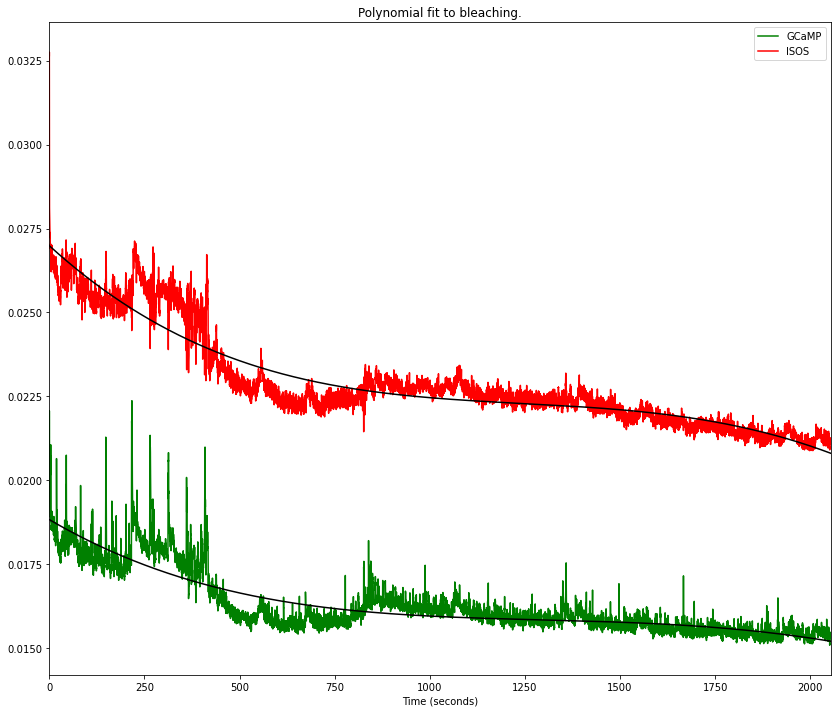

In [43]:
# Fit 4th order polynomial to GCaMP signal.
coefs_GCaMP = np.polyfit(time_seconds, GCaMP_denoised, deg=4)
GCaMP_polyfit = np.polyval(coefs_GCaMP, time_seconds)

# Fit 4th order polynomial to TdTomato signal.
coefs_ISOS = np.polyfit(time_seconds, ISOS_denoised, deg=4)
ISOS_polyfit = np.polyval(coefs_ISOS, time_seconds)

# Plot fits
plt.plot(time_seconds, GCaMP_denoised, 'g', label='GCaMP')
plt.plot(time_seconds, GCaMP_polyfit,'k', linewidth=1.5) 
plt.plot(time_seconds, ISOS_denoised, 'r', label='ISOS')
plt.plot(time_seconds, ISOS_polyfit,'k', linewidth=1.5) 
plt.title('Polynomial fit to bleaching.')
plt.xlabel('Time (seconds)')
plt.legend()

Subtract the polynomial fit from the signals.

Text(0.5, 0, 'Time (seconds)')

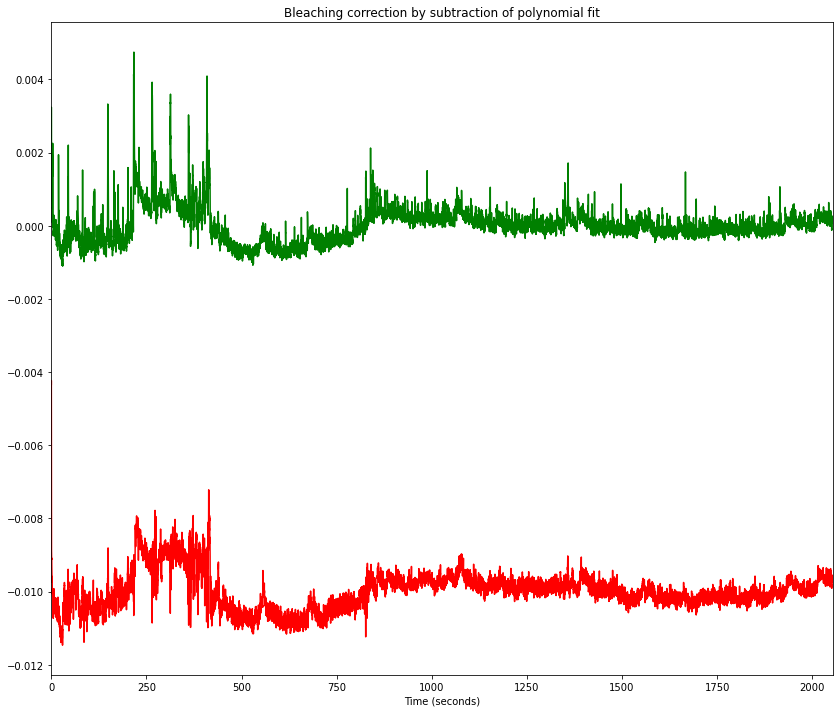

In [45]:
GCaMP_ps = GCaMP_denoised - GCaMP_polyfit
ISOS_ps = ISOS_denoised - ISOS_polyfit

plt.plot(time_seconds, GCaMP_ps    , 'g', label='GCaMP')
plt.plot(time_seconds, ISOS_ps-0.01, 'r', label='ISOS')
plt.title('Bleaching correction by subtraction of polynomial fit')
plt.xlabel('Time (seconds)')

# Motion correction

We now do motion correction by finding the best linear fit of the TdTomato signal to the GCaMP signal and subtracting this estimated motion component from the GCaMP signal.  We will use the data that was bleaching corrected with highpass filtering for the following steps.

Slope    : 0.749
R-squared: 0.569


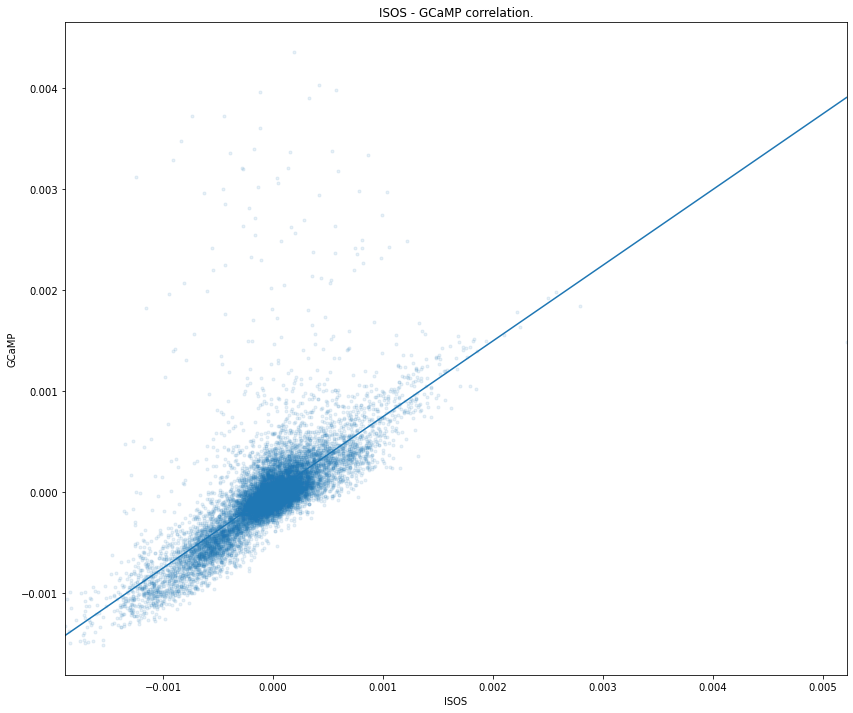

In [46]:
slope, intercept, r_value, p_value, std_err = linregress(x=ISOS_highpass, y=GCaMP_highpass)

plt.scatter(ISOS_highpass[::5], GCaMP_highpass[::5],alpha=0.1, marker='.')
x = np.array(plt.xlim())
plt.plot(x, intercept+slope*x)
plt.xlabel('ISOS')
plt.ylabel('GCaMP')
plt.title('ISOS - GCaMP correlation.')

print('Slope    : {:.3f}'.format(slope))
print('R-squared: {:.3f}'.format(r_value**2))

Calculate the estimated motion component of the GCaMP signal and subtract to get motion corrected signal.

(1.0, 2053.0666666666666)

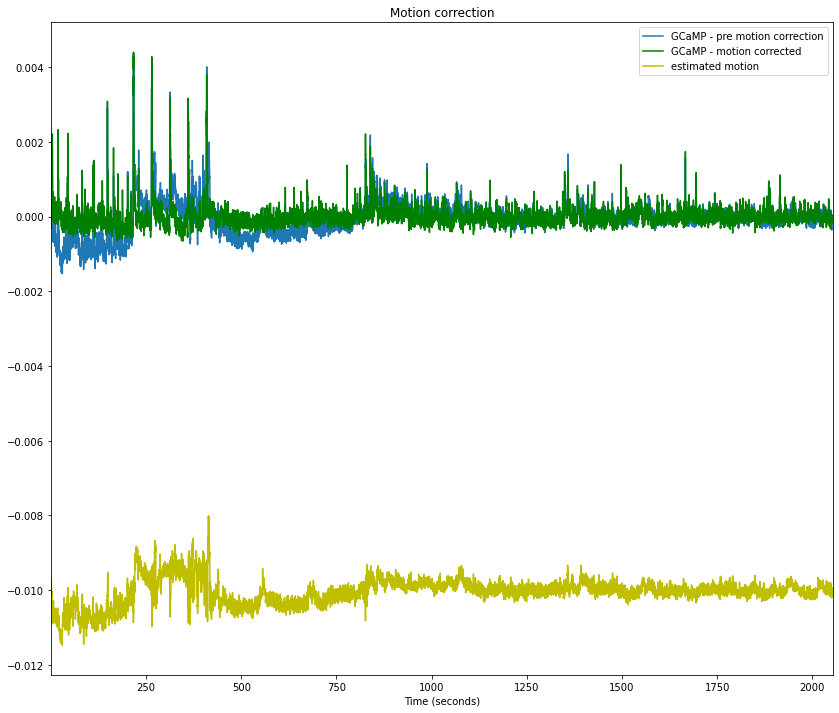

In [50]:
GCaMP_est_motion = intercept + slope * ISOS_highpass
GCaMP_corrected = GCaMP_highpass - GCaMP_est_motion

plt.plot(time_seconds, GCaMP_highpass  , label='GCaMP - pre motion correction')
plt.plot(time_seconds, GCaMP_corrected, 'g', label='GCaMP - motion corrected')
plt.plot(time_seconds, GCaMP_est_motion - 0.01, 'y', label='estimated motion')
plt.xlabel('Time (seconds)')
plt.title('Motion correction')
plt.legend()
plt.xlim(1)

# dF/F

Convert the motion corrected signal into dF/F.  The dF is just the motion corrected signal plotted above.  The baseline fluorescence F changes over the course of the session due to photobleaching.  We estimate F as a function of session time by lowpass filtering the GCaMP signal with a very low (0.001Hz) cutoff frequency.

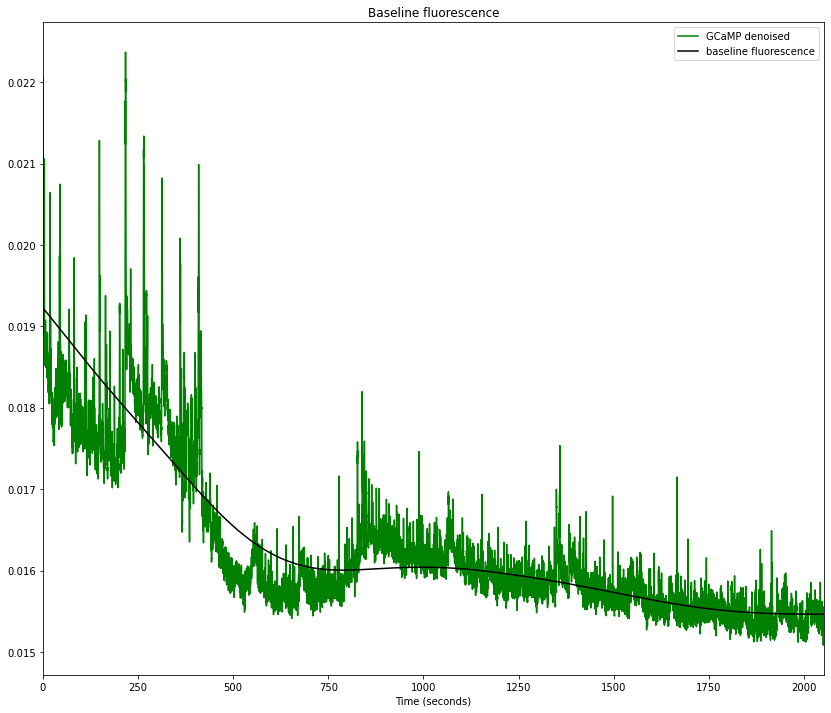

In [52]:
b,a = butter(2, 0.001, btype='low', fs=fs)
baseline_fluorescence = filtfilt(b,a, GCaMP_denoised, padtype='even')

plt.plot(time_seconds, GCaMP_denoised       , 'g', label='GCaMP denoised')
plt.plot(time_seconds, baseline_fluorescence, 'k', label='baseline fluorescence')
plt.xlabel('Time (seconds)')
plt.title('Baseline fluorescence')
plt.legend();

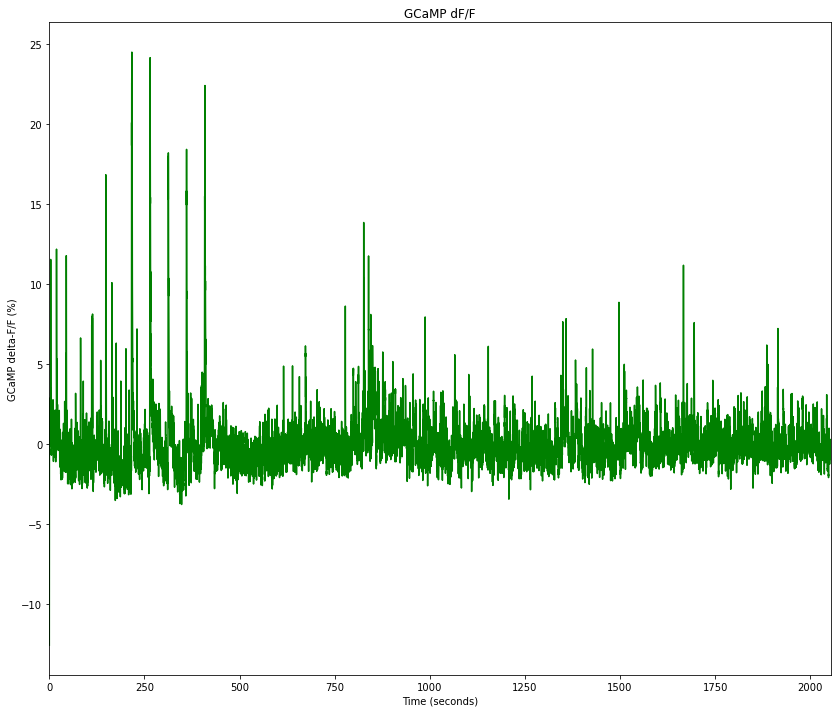

In [54]:
GCaMP_dF_F = GCaMP_corrected/baseline_fluorescence

plt.plot(time_seconds, GCaMP_dF_F*100, 'g')
plt.xlabel('Time (seconds)')
plt.ylabel('GCaMP delta-F/F (%)')
plt.title('GCaMP dF/F')
plt.xlim();

# Putting it all together. 

The above a lot of code, but in reality these preprocessing steps are straight forward. Below puts them all together. 

In [80]:
def preprocess(raw, time_seconds, fs):
    '''This function denoises GCaMP or ISOS signals
    with a median ad lowpass filter. Then it fits a 4th order 
    polyonmial to the data subtracts the polyomial fit from the
    raw data.'''

    # Median and lowpass filter with filtfilt
    denoised_med = medfilt(raw, kernel_size=5)

    b,a = butter(2, 10, btype='low', fs=fs)
    denoised = filtfilt(b,a, denoised_med)

    # Fit 4th order polynomial to GCaMP signal and sutract
    coefs = np.polyfit(time_seconds, denoised, deg=4)
    polyfit_data = np.polyval(coefs, time_seconds)

    debleached = denoised - polyfit_data
    
    return debleached, denoised

def correct_motion(GCaMP_prepro, ISOS_prepro):
    '''This function takes preprocessed GCaMP and Isosbestic
    sigals and finds the linear fit, then estimates the 
    motion correction and substracts it from GCaMP.'''
    
    # find linear fit
    slope, intercept, r_value, p_value, std_err = linregress(x=ISOS_prepro, y=GCaMP_prepro)
    
    # estimate motion correction and subtract
    GCaMP_est_motion = intercept + slope * ISOS_prepro
    GCaMP_corrected = GCaMP_prepro - GCaMP_est_motion
    
    return GCaMP_corrected

def deltaF_F(GCaMP_correct, denoised, fs):
    '''This function calculates the dF/F using the 
    denoised data and the motion corrected.'''
    
    b,a = butter(2, 0.001, btype='low', fs=fs)
    baseline_fluorescence = filtfilt(b,a, denoised, padtype='even')
    
    GCaMP_dF_F = GCaMP_corrected/baseline_fluorescence
    
    return GCaMP_dF_F

Text(0.5, 1.0, 'GCaMP dF/F')

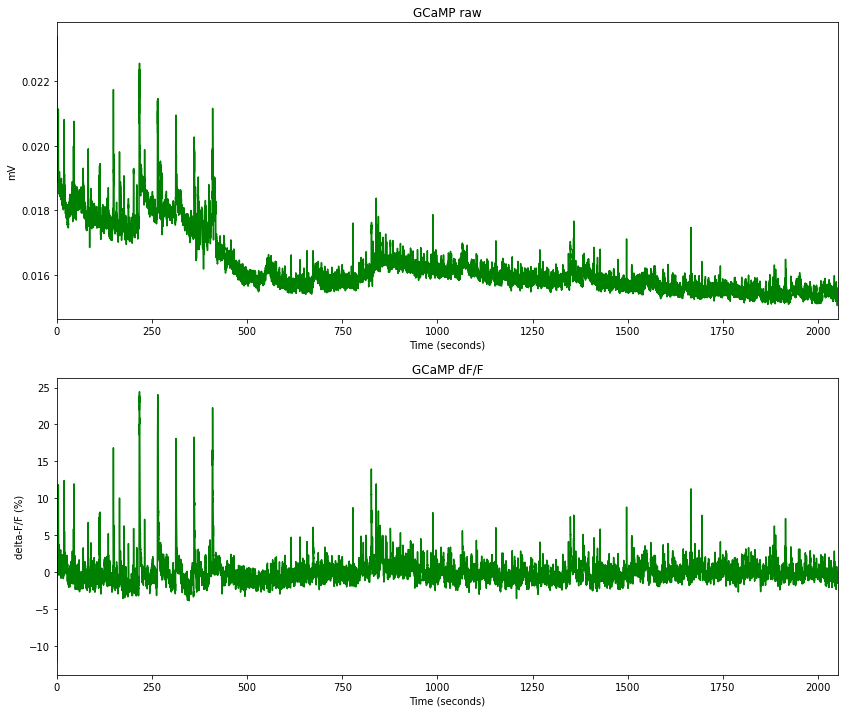

In [81]:
# Preprocess from raw to dF/F
GCaMP_debleached, GCaMP_denoised = preprocess(GCaMP_raw, time_seconds, fs)
ISOS_debleached, x = preprocess(ISOS_raw, time_seconds, fs)

GCaMP_corrected = correct_motion(GCaMP_debleached, ISOS_debleached)

GCaMP_dF_F = deltaF_F(GCaMP_corrected, GCaMP_denoised, fs)

# Visualize for confirmation
plt.figure()

plt.subplot(2,1,1)
plt.plot(time_seconds, GCaMP_raw, 'g')
plt.xlabel('Time (seconds)')
plt.ylabel('mV')
plt.title('GCaMP raw')


plt.subplot(2,1,2)
plt.plot(time_seconds, GCaMP_dF_F*100, 'g')
plt.xlabel('Time (seconds)')
plt.ylabel('delta-F/F (%)')
plt.title('GCaMP dF/F')

As you can see, by creating functions, preprocessing can be reduced to only a three-step process (and four lines of code). You could easily take this one step further by creating a single function to call all three steps, thus reducing it to a single line of code. 

The next steps will be scaling this up. Depending on computer specs, you can near-instantly preprocess hundreds of recordings simultaneously using Pytho. After that we will focus on chunking and averaging data around time points of interest (CSs). 